In [1]:

import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)


In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#!pip install ipython-autotime

#%load_ext autotime

In [4]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [5]:
#!pip install opencv-python==4.4.0.44
#!pip install opencv-contrib-python==4.4.0.44

In [6]:

class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()
  


In [7]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers




In [8]:

files_all=[]
for file in os.listdir("/content/drive/My Drive/Uni_img"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/My Drive/Uni_img/'

centre_file = folder_path + files_all[15]
left_files_path_rev = []
right_files_path = []

for file in files_all[:31]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[30:61]:
  right_files_path.append(folder_path + file)

In [9]:
from PIL.ExifTags import TAGS
from PIL.ExifTags import GPSTAGS
from PIL import Image
def get_exif(filename):
    image = Image.open(filename)
    image.verify()
    return image._getexif()
    
def get_labeled_exif(exif):
    labeled = {}
    for (key, val) in exif.items():
        labeled[TAGS.get(key)] = val

    return labeled


def get_geotagging(exif):
    if not exif:
        raise ValueError("No EXIF metadata found")

    geotagging = {}
    for (idx, tag) in TAGS.items():
        if tag == 'GPSInfo':
            if idx not in exif:
                raise ValueError("No EXIF geotagging found")

            for (key, val) in GPSTAGS.items():
                if key in exif[idx]:
                    geotagging[val] = exif[idx][key]
    return geotagging

def get_decimal_from_dms(dms, ref):

    degrees = dms[0][0] / dms[0][1]
    minutes = dms[1][0] / dms[1][1] / 60.0
    seconds = dms[2][0] / dms[2][1] / 3600.0

    if ref in ['S', 'W']:
        degrees = -degrees
        minutes = -minutes
        seconds = -seconds

    return round(degrees + minutes + seconds, 5)

def get_coordinates(geotags):
    lat = get_decimal_from_dms(geotags['GPSLatitude'], geotags['GPSLatitudeRef'])

    lon = get_decimal_from_dms(geotags['GPSLongitude'], geotags['GPSLongitudeRef'])

    return (lat,lon)


In [11]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)



100%|██████████| 31/31 [00:23<00:00,  1.31it/s]


In [24]:

images_left_bgr_no_enhance = []
images_right_bgr_no_enhance = []


for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_left_bgr_no_enhance.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
  images_right_bgr_no_enhance.append(right_img)



100%|██████████| 31/31 [00:12<00:00,  2.57it/s]


In [46]:
Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for imgs in tqdm(images_left_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [00:30<00:00,  1.02it/s]


In [ ]:
orb = cv2.ORB_create(5000)


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for imgs in tqdm(images_left_bgr):
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [00:04<00:00,  7.24it/s]

time: 8.89 s (started: 2021-06-15 15:24:25 +00:00)


In [ ]:
kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [02:26<00:00,  4.71s/it]

time: 4min 53s (started: 2021-06-15 15:24:34 +00:00)


In [15]:
tqdm = partial(tqdm, position=0, leave=True)

time: 1.19 ms (started: 2021-06-15 15:51:44 +00:00)


In [ ]:
akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for imgs in tqdm(images_left_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [00:25<00:00,  1.20it/s]

time: 52.5 s (started: 2021-06-15 15:29:28 +00:00)


In [ ]:
star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for imgs in tqdm(images_left_bgr):
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [00:04<00:00,  6.39it/s]

time: 9.88 s (started: 2021-06-15 15:30:21 +00:00)


In [13]:
sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]

for imgs in tqdm(images_left_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [00:59<00:00,  1.92s/it]


In [67]:
surf  = cv2.xfeatures2d.SURF_create()
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for imgs in tqdm(images_left_bgr):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

100%|██████████| 31/31 [02:18<00:00,  4.47s/it]


In [ ]:
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

time: 7.07 ms (started: 2021-06-15 15:36:05 +00:00)


In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for imgs in tqdm(images_left_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for imgs in tqdm(images_right_bgr):
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

  3%|▎         | 1/31 [00:01<00:57,  1.91s/it]

In [ ]:
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for lfpth in tqdm(images_left):
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  points_all_left_superpoint.append(pts_1.T)


for rfpth in tqdm(images_right):
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  points_all_right_superpoint.append(pts_1.T)

  0%|          | 0/31 [00:00<?, ?it/s]

number of pts selected : 54389


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
  6%|▋         | 2/31 [00:00<00:10,  2.81it/s]

number of pts selected : 41692


 10%|▉         | 3/31 [00:00<00:09,  2.97it/s]

number of pts selected : 46009


 13%|█▎        | 4/31 [00:01<00:08,  3.12it/s]

number of pts selected : 45884


 16%|█▌        | 5/31 [00:01<00:08,  3.23it/s]

number of pts selected : 45234
number of pts selected : 52587


 19%|█▉        | 6/31 [00:01<00:07,  3.21it/s]

number of pts selected : 53105


 23%|██▎       | 7/31 [00:02<00:07,  3.19it/s]

number of pts selected : 66782


 26%|██▌       | 8/31 [00:02<00:07,  3.02it/s]

number of pts selected : 65203


 29%|██▉       | 9/31 [00:02<00:07,  2.93it/s]

number of pts selected : 67908


 32%|███▏      | 10/31 [00:03<00:07,  2.85it/s]

number of pts selected : 65236


 35%|███▌      | 11/31 [00:03<00:07,  2.84it/s]

number of pts selected : 66288


 39%|███▊      | 12/31 [00:03<00:06,  2.82it/s]

number of pts selected : 67292


 42%|████▏     | 13/31 [00:04<00:06,  2.79it/s]

number of pts selected : 74482


 45%|████▌     | 14/31 [00:04<00:06,  2.73it/s]

number of pts selected : 80466


 48%|████▊     | 15/31 [00:05<00:06,  2.64it/s]

number of pts selected : 79406


 52%|█████▏    | 16/31 [00:05<00:05,  2.60it/s]

number of pts selected : 77186


 55%|█████▍    | 17/31 [00:05<00:05,  2.59it/s]

number of pts selected : 78522


 58%|█████▊    | 18/31 [00:06<00:05,  2.56it/s]

number of pts selected : 76461


 61%|██████▏   | 19/31 [00:06<00:04,  2.56it/s]

number of pts selected : 75079


 65%|██████▍   | 20/31 [00:07<00:04,  2.56it/s]

number of pts selected : 74653


 68%|██████▊   | 21/31 [00:07<00:03,  2.53it/s]

number of pts selected : 72241


 71%|███████   | 22/31 [00:07<00:03,  2.56it/s]

number of pts selected : 76421


 74%|███████▍  | 23/31 [00:08<00:03,  2.56it/s]

number of pts selected : 76524


 77%|███████▋  | 24/31 [00:08<00:02,  2.55it/s]

number of pts selected : 77484


 81%|████████  | 25/31 [00:09<00:02,  2.53it/s]

number of pts selected : 76790


 84%|████████▍ | 26/31 [00:09<00:01,  2.53it/s]

number of pts selected : 72526


 87%|████████▋ | 27/31 [00:09<00:01,  2.56it/s]

number of pts selected : 74990


 90%|█████████ | 28/31 [00:10<00:01,  2.55it/s]

number of pts selected : 73152


 94%|█████████▎| 29/31 [00:10<00:00,  2.57it/s]

number of pts selected : 75194


 97%|█████████▋| 30/31 [00:11<00:00,  2.57it/s]

number of pts selected : 72677


  0%|          | 0/31 [00:00<?, ?it/s]

number of pts selected : 54389


  3%|▎         | 1/31 [00:00<00:09,  3.16it/s]

number of pts selected : 57668


  6%|▋         | 2/31 [00:00<00:09,  3.11it/s]

number of pts selected : 72511


 10%|▉         | 3/31 [00:01<00:09,  2.95it/s]

number of pts selected : 80589


 13%|█▎        | 4/31 [00:01<00:09,  2.79it/s]

number of pts selected : 81288


 16%|█▌        | 5/31 [00:01<00:09,  2.67it/s]

number of pts selected : 80120


 19%|█▉        | 6/31 [00:02<00:09,  2.56it/s]

number of pts selected : 68019


 23%|██▎       | 7/31 [00:02<00:09,  2.60it/s]

number of pts selected : 70150


 26%|██▌       | 8/31 [00:03<00:08,  2.63it/s]

number of pts selected : 67211


 29%|██▉       | 9/31 [00:03<00:08,  2.68it/s]

number of pts selected : 67542


 32%|███▏      | 10/31 [00:03<00:07,  2.71it/s]

number of pts selected : 60955


 35%|███▌      | 11/31 [00:04<00:07,  2.79it/s]

number of pts selected : 66493


 39%|███▊      | 12/31 [00:04<00:06,  2.81it/s]

number of pts selected : 67367


 42%|████▏     | 13/31 [00:04<00:06,  2.78it/s]

number of pts selected : 66701


 45%|████▌     | 14/31 [00:05<00:06,  2.77it/s]

number of pts selected : 73340


 48%|████▊     | 15/31 [00:05<00:05,  2.71it/s]

number of pts selected : 78344


 52%|█████▏    | 16/31 [00:05<00:05,  2.64it/s]

number of pts selected : 82778


 55%|█████▍    | 17/31 [00:06<00:05,  2.56it/s]

number of pts selected : 84116


 58%|█████▊    | 18/31 [00:06<00:05,  2.50it/s]

number of pts selected : 78771


 61%|██████▏   | 19/31 [00:07<00:04,  2.50it/s]

number of pts selected : 80455


 65%|██████▍   | 20/31 [00:07<00:04,  2.48it/s]

number of pts selected : 68537


 68%|██████▊   | 21/31 [00:07<00:03,  2.54it/s]

number of pts selected : 70715


 71%|███████   | 22/31 [00:08<00:03,  2.57it/s]

number of pts selected : 55142


 74%|███████▍  | 23/31 [00:08<00:02,  2.69it/s]

number of pts selected : 62314


 77%|███████▋  | 24/31 [00:09<00:02,  2.73it/s]

number of pts selected : 54463


 81%|████████  | 25/31 [00:09<00:02,  2.85it/s]

number of pts selected : 51782


 84%|████████▍ | 26/31 [00:09<00:01,  2.95it/s]

number of pts selected : 54109


 87%|████████▋ | 27/31 [00:09<00:01,  3.00it/s]

number of pts selected : 56685


 90%|█████████ | 28/31 [00:10<00:00,  3.02it/s]

number of pts selected : 55013


 97%|█████████▋| 30/31 [00:10<00:00,  3.12it/s]

number of pts selected : 50638


100%|██████████| 31/31 [00:11<00:00,  2.76it/s]

number of pts selected : 47756
time: 22.6 s (started: 2021-06-15 15:37:53 +00:00)


In [60]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh)
    inliers = inliers.flatten()
    return H, inliers

In [15]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [61]:

def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.8,thresh=4,disp=False):
  FLANN_INDEX_KDTREE = 2
  index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
  search_params = dict(checks=50)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  #flann = cv2.BFMatcher()

  lff1 = np.float32(descripts[0])
  lff = np.float32(descripts[1])


  matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)

  print("\nNumber of matches",len(matches_lf1_lf))

  matches_4 = []
  ratio = ratio
  # loop over the raw matches
  for m in matches_lf1_lf:
    # ensure the distance is within a certain ratio of each
    # other (i.e. Lowe’s ratio test)
    if len(m) == 2 and m[0].distance < m[1].distance * ratio:
        #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])

  print("Number of matches After Lowe's Ratio",len(matches_4))
  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  
  Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  
  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  '''
  if len(inlier_matchset)<50:
    matches_4 = []
    ratio = 0.67
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
    '''
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [17]:
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
print(left_files_path)

['/content/drive/My Drive/Uni_img/IX-11-01917_0004_0031.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0030.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0029.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0028.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0027.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0026.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0025.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0024.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0023.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0022.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0021.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0020.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0019.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0018.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0017.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0016.JPG', '/content/drive/My Driv

In [ ]:
print(right_files_path)

['/content/drive/My Drive/Uni_img/IX-11-01917_0004_0031.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0032.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0033.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0034.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0035.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0036.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0037.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0038.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0039.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0040.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0041.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0042.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0043.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0044.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0045.JPG', '/content/drive/My Drive/Uni_img/IX-11-01917_0004_0046.JPG', '/content/drive/My Driv

In [62]:
H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.9,6)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.9,6)
  H_right_brisk.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  3%|▎         | 1/31 [00:02<01:26,  2.89s/it]


Number of matches 34530
Number of matches After Lowe's Ratio 4866
Number of Robust matches 350




  6%|▋         | 2/31 [00:05<01:20,  2.77s/it]


Number of matches 24599
Number of matches After Lowe's Ratio 3574
Number of Robust matches 19




 10%|▉         | 3/31 [00:07<01:09,  2.50s/it]


Number of matches 24704
Number of matches After Lowe's Ratio 4926
Number of Robust matches 1134




 13%|█▎        | 4/31 [00:08<01:00,  2.25s/it]


Number of matches 21196
Number of matches After Lowe's Ratio 4488
Number of Robust matches 1197




 16%|█▌        | 5/31 [00:10<00:53,  2.06s/it]


Number of matches 26252
Number of matches After Lowe's Ratio 5083
Number of Robust matches 1139




 19%|█▉        | 6/31 [00:12<00:53,  2.12s/it]


Number of matches 32005
Number of matches After Lowe's Ratio 6429
Number of Robust matches 1452




 23%|██▎       | 7/31 [00:15<00:58,  2.44s/it]


Number of matches 44696
Number of matches After Lowe's Ratio 7777
Number of Robust matches 1274




 26%|██▌       | 8/31 [00:20<01:13,  3.20s/it]


Number of matches 48468
Number of matches After Lowe's Ratio 9023
Number of Robust matches 1617



Number of matches 44596
Number of matches After Lowe's Ratio 8228


 29%|██▉       | 9/31 [00:25<01:21,  3.71s/it]

Number of Robust matches 1669




 32%|███▏      | 10/31 [00:29<01:18,  3.75s/it]


Number of matches 35503
Number of matches After Lowe's Ratio 7135
Number of Robust matches 2262




 35%|███▌      | 11/31 [00:32<01:09,  3.50s/it]


Number of matches 32924
Number of matches After Lowe's Ratio 7557
Number of Robust matches 2741




 39%|███▊      | 12/31 [00:35<01:00,  3.20s/it]


Number of matches 30917
Number of matches After Lowe's Ratio 7193
Number of Robust matches 2860




 42%|████▏     | 13/31 [00:37<00:53,  2.95s/it]


Number of matches 30511
Number of matches After Lowe's Ratio 7290
Number of Robust matches 3131




 45%|████▌     | 14/31 [00:40<00:48,  2.87s/it]


Number of matches 36828
Number of matches After Lowe's Ratio 8022
Number of Robust matches 2617




 48%|████▊     | 15/31 [00:43<00:48,  3.02s/it]


Number of matches 39748
Number of matches After Lowe's Ratio 8748
Number of Robust matches 2823




 52%|█████▏    | 16/31 [00:47<00:47,  3.16s/it]


Number of matches 38033
Number of matches After Lowe's Ratio 8542
Number of Robust matches 3033




 55%|█████▍    | 17/31 [00:50<00:46,  3.29s/it]


Number of matches 39826
Number of matches After Lowe's Ratio 8588
Number of Robust matches 2880




 58%|█████▊    | 18/31 [00:53<00:42,  3.30s/it]


Number of matches 33296
Number of matches After Lowe's Ratio 6731
Number of Robust matches 2089




 61%|██████▏   | 19/31 [00:56<00:37,  3.12s/it]


Number of matches 31758
Number of matches After Lowe's Ratio 8327
Number of Robust matches 3794




 65%|██████▍   | 20/31 [00:59<00:31,  2.90s/it]


Number of matches 31028
Number of matches After Lowe's Ratio 7661
Number of Robust matches 3428




 68%|██████▊   | 21/31 [01:01<00:26,  2.69s/it]


Number of matches 27881
Number of matches After Lowe's Ratio 5708
Number of Robust matches 1852




 71%|███████   | 22/31 [01:03<00:22,  2.55s/it]


Number of matches 27362
Number of matches After Lowe's Ratio 5708
Number of Robust matches 1898




 74%|███████▍  | 23/31 [01:05<00:19,  2.39s/it]


Number of matches 27680
Number of matches After Lowe's Ratio 6447
Number of Robust matches 2656




 77%|███████▋  | 24/31 [01:07<00:16,  2.37s/it]


Number of matches 32777
Number of matches After Lowe's Ratio 7232
Number of Robust matches 2103




 81%|████████  | 25/31 [01:10<00:14,  2.39s/it]


Number of matches 27042
Number of matches After Lowe's Ratio 6107
Number of Robust matches 2377




 84%|████████▍ | 26/31 [01:12<00:11,  2.30s/it]


Number of matches 29160
Number of matches After Lowe's Ratio 6279
Number of Robust matches 1374




 87%|████████▋ | 27/31 [01:14<00:09,  2.36s/it]


Number of matches 32830
Number of matches After Lowe's Ratio 7912
Number of Robust matches 2155




 90%|█████████ | 28/31 [01:17<00:07,  2.50s/it]


Number of matches 33004
Number of matches After Lowe's Ratio 6516
Number of Robust matches 1225




 94%|█████████▎| 29/31 [01:20<00:05,  2.67s/it]


Number of matches 35929
Number of matches After Lowe's Ratio 8248
Number of Robust matches 1935




  0%|          | 0/31 [00:00<?, ?it/s]


Number of matches 25316
Number of matches After Lowe's Ratio 4221
Number of Robust matches 323




  3%|▎         | 1/31 [00:03<01:34,  3.14s/it]


Number of matches 33725
Number of matches After Lowe's Ratio 5649
Number of Robust matches 1241




  6%|▋         | 2/31 [00:05<01:27,  3.02s/it]


Number of matches 30297
Number of matches After Lowe's Ratio 5420
Number of Robust matches 528




 10%|▉         | 3/31 [00:08<01:20,  2.86s/it]


Number of matches 32058
Number of matches After Lowe's Ratio 6200
Number of Robust matches 1112




 13%|█▎        | 4/31 [00:11<01:19,  2.95s/it]


Number of matches 37987
Number of matches After Lowe's Ratio 8106
Number of Robust matches 1669



Number of matches 43958
Number of matches After Lowe's Ratio 8507


 16%|█▌        | 5/31 [00:15<01:24,  3.25s/it]

Number of Robust matches 1836




 19%|█▉        | 6/31 [00:19<01:26,  3.46s/it]


Number of matches 35870
Number of matches After Lowe's Ratio 6270
Number of Robust matches 1846




 23%|██▎       | 7/31 [00:22<01:20,  3.37s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 6614
Number of Robust matches 2469




 26%|██▌       | 8/31 [00:25<01:11,  3.11s/it]


Number of matches 31815
Number of matches After Lowe's Ratio 6718
Number of Robust matches 2653




 29%|██▉       | 9/31 [00:27<01:03,  2.91s/it]


Number of matches 32135
Number of matches After Lowe's Ratio 6514
Number of Robust matches 2288




 32%|███▏      | 10/31 [00:30<00:58,  2.80s/it]


Number of matches 31427
Number of matches After Lowe's Ratio 6334
Number of Robust matches 2106




 35%|███▌      | 11/31 [00:32<00:53,  2.68s/it]


Number of matches 31280
Number of matches After Lowe's Ratio 6835
Number of Robust matches 2660




 39%|███▊      | 12/31 [00:34<00:50,  2.64s/it]


Number of matches 33078
Number of matches After Lowe's Ratio 8182
Number of Robust matches 3707




 42%|████▏     | 13/31 [00:37<00:47,  2.61s/it]


Number of matches 32047
Number of matches After Lowe's Ratio 7506
Number of Robust matches 3385




 45%|████▌     | 14/31 [00:40<00:43,  2.58s/it]


Number of matches 30911
Number of matches After Lowe's Ratio 7058
Number of Robust matches 2971




 48%|████▊     | 15/31 [00:42<00:41,  2.61s/it]


Number of matches 34839
Number of matches After Lowe's Ratio 8066
Number of Robust matches 3305




 52%|█████▏    | 16/31 [00:45<00:42,  2.80s/it]


Number of matches 37547
Number of matches After Lowe's Ratio 8142
Number of Robust matches 3305




 55%|█████▍    | 17/31 [00:49<00:41,  2.97s/it]


Number of matches 37734
Number of matches After Lowe's Ratio 9155
Number of Robust matches 4514




 58%|█████▊    | 18/31 [00:52<00:39,  3.02s/it]


Number of matches 32146
Number of matches After Lowe's Ratio 6856
Number of Robust matches 2968




 61%|██████▏   | 19/31 [00:55<00:34,  2.88s/it]


Number of matches 32653
Number of matches After Lowe's Ratio 7464
Number of Robust matches 3004




 65%|██████▍   | 20/31 [00:57<00:30,  2.75s/it]


Number of matches 26430
Number of matches After Lowe's Ratio 6079
Number of Robust matches 2416




 68%|██████▊   | 21/31 [00:59<00:25,  2.53s/it]


Number of matches 31108
Number of matches After Lowe's Ratio 5502
Number of Robust matches 1226




 71%|███████   | 22/31 [01:01<00:21,  2.40s/it]


Number of matches 22854
Number of matches After Lowe's Ratio 5048
Number of Robust matches 1662




 74%|███████▍  | 23/31 [01:03<00:17,  2.23s/it]


Number of matches 32280
Number of matches After Lowe's Ratio 5603
Number of Robust matches 1039




 77%|███████▋  | 24/31 [01:05<00:15,  2.24s/it]


Number of matches 26534
Number of matches After Lowe's Ratio 5651
Number of Robust matches 1936




 81%|████████  | 25/31 [01:07<00:12,  2.13s/it]


Number of matches 28302
Number of matches After Lowe's Ratio 5911
Number of Robust matches 1550




 84%|████████▍ | 26/31 [01:09<00:10,  2.07s/it]


Number of matches 23435
Number of matches After Lowe's Ratio 5032
Number of Robust matches 1695




 87%|████████▋ | 27/31 [01:11<00:07,  1.92s/it]


Number of matches 26028
Number of matches After Lowe's Ratio 5156
Number of Robust matches 1427




 90%|█████████ | 28/31 [01:13<00:05,  1.93s/it]


Number of matches 30921
Number of matches After Lowe's Ratio 4364
Number of Robust matches 10




 94%|█████████▎| 29/31 [01:15<00:04,  2.05s/it]


Number of matches 25059
Number of matches After Lowe's Ratio 4123
Number of Robust matches 471




 97%|█████████▋| 30/31 [01:17<00:01,  1.93s/it]


Number of matches 23035
Number of matches After Lowe's Ratio 3779
Number of Robust matches 252




In [40]:
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.5)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.5)
  H_right_sift.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  3%|▎         | 1/31 [00:05<02:54,  5.81s/it]


Number of matches 38187
Number of matches After Lowe's Ratio 430
Number of Robust matches 292




  6%|▋         | 2/31 [00:11<02:46,  5.75s/it]


Number of matches 35025
Number of matches After Lowe's Ratio 128
Number of Robust matches 85




 10%|▉         | 3/31 [00:16<02:35,  5.54s/it]


Number of matches 35065
Number of matches After Lowe's Ratio 1061
Number of Robust matches 840




 13%|█▎        | 4/31 [00:21<02:23,  5.33s/it]


Number of matches 32733
Number of matches After Lowe's Ratio 1225
Number of Robust matches 849




 16%|█▌        | 5/31 [00:26<02:14,  5.17s/it]


Number of matches 33968
Number of matches After Lowe's Ratio 1138
Number of Robust matches 941




 19%|█▉        | 6/31 [00:31<02:08,  5.16s/it]


Number of matches 39070
Number of matches After Lowe's Ratio 1505
Number of Robust matches 1213




 23%|██▎       | 7/31 [00:37<02:12,  5.54s/it]


Number of matches 41604
Number of matches After Lowe's Ratio 1063
Number of Robust matches 648




 26%|██▌       | 8/31 [00:44<02:18,  6.01s/it]


Number of matches 43881
Number of matches After Lowe's Ratio 1003
Number of Robust matches 622




 29%|██▉       | 9/31 [00:51<02:17,  6.23s/it]


Number of matches 40123
Number of matches After Lowe's Ratio 943
Number of Robust matches 572




 32%|███▏      | 10/31 [00:57<02:08,  6.12s/it]


Number of matches 36596
Number of matches After Lowe's Ratio 1222
Number of Robust matches 805




 35%|███▌      | 11/31 [01:02<01:55,  5.78s/it]


Number of matches 33986
Number of matches After Lowe's Ratio 1621
Number of Robust matches 1362




 39%|███▊      | 12/31 [01:06<01:42,  5.41s/it]


Number of matches 30652
Number of matches After Lowe's Ratio 1777
Number of Robust matches 1444




 42%|████▏     | 13/31 [01:10<01:28,  4.94s/it]


Number of matches 29868
Number of matches After Lowe's Ratio 2049
Number of Robust matches 1790




 45%|████▌     | 14/31 [01:14<01:17,  4.58s/it]


Number of matches 28588
Number of matches After Lowe's Ratio 1965
Number of Robust matches 1434




 48%|████▊     | 15/31 [01:18<01:08,  4.29s/it]


Number of matches 28661
Number of matches After Lowe's Ratio 2336
Number of Robust matches 1720




 52%|█████▏    | 16/31 [01:21<01:00,  4.06s/it]


Number of matches 27785
Number of matches After Lowe's Ratio 2606
Number of Robust matches 1948




 55%|█████▍    | 17/31 [01:25<00:53,  3.86s/it]


Number of matches 27261
Number of matches After Lowe's Ratio 2584
Number of Robust matches 1996




 58%|█████▊    | 18/31 [01:28<00:47,  3.62s/it]


Number of matches 23943
Number of matches After Lowe's Ratio 1433
Number of Robust matches 1119




 61%|██████▏   | 19/31 [01:30<00:40,  3.35s/it]


Number of matches 23206
Number of matches After Lowe's Ratio 2807
Number of Robust matches 2411




 65%|██████▍   | 20/31 [01:33<00:34,  3.16s/it]


Number of matches 27133
Number of matches After Lowe's Ratio 2491
Number of Robust matches 2171




 68%|██████▊   | 21/31 [01:36<00:32,  3.23s/it]


Number of matches 28897
Number of matches After Lowe's Ratio 1415
Number of Robust matches 1166




 71%|███████   | 22/31 [01:40<00:30,  3.36s/it]


Number of matches 30356
Number of matches After Lowe's Ratio 1379
Number of Robust matches 1173




 74%|███████▍  | 23/31 [01:44<00:27,  3.46s/it]


Number of matches 30770
Number of matches After Lowe's Ratio 1960
Number of Robust matches 1519




 77%|███████▋  | 24/31 [01:48<00:24,  3.57s/it]


Number of matches 30376
Number of matches After Lowe's Ratio 1301
Number of Robust matches 1042




 81%|████████  | 25/31 [01:51<00:21,  3.63s/it]


Number of matches 30122
Number of matches After Lowe's Ratio 1687
Number of Robust matches 1211




 84%|████████▍ | 26/31 [01:55<00:18,  3.69s/it]


Number of matches 30579
Number of matches After Lowe's Ratio 1474
Number of Robust matches 1000




 87%|████████▋ | 27/31 [01:59<00:14,  3.69s/it]


Number of matches 29556
Number of matches After Lowe's Ratio 2194
Number of Robust matches 1283




 90%|█████████ | 28/31 [02:03<00:11,  3.72s/it]


Number of matches 30860
Number of matches After Lowe's Ratio 1144
Number of Robust matches 613




 94%|█████████▎| 29/31 [02:07<00:07,  3.76s/it]


Number of matches 30396
Number of matches After Lowe's Ratio 1902
Number of Robust matches 818




  0%|          | 0/31 [00:00<?, ?it/s]


Number of matches 26655
Number of matches After Lowe's Ratio 452
Number of Robust matches 238




  3%|▎         | 1/31 [00:05<02:56,  5.89s/it]


Number of matches 39115
Number of matches After Lowe's Ratio 1120
Number of Robust matches 821




  6%|▋         | 2/31 [00:11<02:46,  5.75s/it]


Number of matches 34271
Number of matches After Lowe's Ratio 579
Number of Robust matches 431




 10%|▉         | 3/31 [00:16<02:32,  5.46s/it]


Number of matches 35656
Number of matches After Lowe's Ratio 1072
Number of Robust matches 639




 13%|█▎        | 4/31 [00:20<02:22,  5.27s/it]


Number of matches 30633
Number of matches After Lowe's Ratio 1057
Number of Robust matches 641




 16%|█▌        | 5/31 [00:24<02:07,  4.90s/it]


Number of matches 35893
Number of matches After Lowe's Ratio 1054
Number of Robust matches 824




 19%|█▉        | 6/31 [00:29<02:01,  4.87s/it]


Number of matches 31039
Number of matches After Lowe's Ratio 1026
Number of Robust matches 807




 23%|██▎       | 7/31 [00:33<01:51,  4.65s/it]


Number of matches 31666
Number of matches After Lowe's Ratio 1261
Number of Robust matches 1032




 26%|██▌       | 8/31 [00:37<01:42,  4.48s/it]


Number of matches 31209
Number of matches After Lowe's Ratio 1739
Number of Robust matches 1397




 29%|██▉       | 9/31 [00:41<01:35,  4.32s/it]


Number of matches 32208
Number of matches After Lowe's Ratio 1620
Number of Robust matches 1283




 32%|███▏      | 10/31 [00:46<01:29,  4.26s/it]


Number of matches 29913
Number of matches After Lowe's Ratio 1946
Number of Robust matches 1643




 35%|███▌      | 11/31 [00:49<01:21,  4.08s/it]


Number of matches 28182
Number of matches After Lowe's Ratio 2441
Number of Robust matches 2112




 39%|███▊      | 12/31 [00:52<01:12,  3.83s/it]


Number of matches 27052
Number of matches After Lowe's Ratio 3134
Number of Robust matches 2634




 42%|████▏     | 13/31 [00:56<01:05,  3.63s/it]


Number of matches 26581
Number of matches After Lowe's Ratio 2774
Number of Robust matches 2419




 45%|████▌     | 14/31 [00:59<00:58,  3.44s/it]


Number of matches 25919
Number of matches After Lowe's Ratio 1958
Number of Robust matches 1745




 48%|████▊     | 15/31 [01:02<00:52,  3.31s/it]


Number of matches 27099
Number of matches After Lowe's Ratio 2111
Number of Robust matches 1695




 52%|█████▏    | 16/31 [01:05<00:49,  3.31s/it]


Number of matches 27282
Number of matches After Lowe's Ratio 1658
Number of Robust matches 1540




 55%|█████▍    | 17/31 [01:08<00:45,  3.28s/it]


Number of matches 27592
Number of matches After Lowe's Ratio 2370
Number of Robust matches 1920




 58%|█████▊    | 18/31 [01:11<00:41,  3.22s/it]


Number of matches 24162
Number of matches After Lowe's Ratio 1363
Number of Robust matches 1107




 61%|██████▏   | 19/31 [01:14<00:37,  3.11s/it]


Number of matches 27909
Number of matches After Lowe's Ratio 1452
Number of Robust matches 1155




 65%|██████▍   | 20/31 [01:17<00:34,  3.15s/it]


Number of matches 23666
Number of matches After Lowe's Ratio 1230
Number of Robust matches 871




 68%|██████▊   | 21/31 [01:20<00:30,  3.06s/it]


Number of matches 31966
Number of matches After Lowe's Ratio 521
Number of Robust matches 402




 71%|███████   | 22/31 [01:24<00:29,  3.29s/it]


Number of matches 27613
Number of matches After Lowe's Ratio 1231
Number of Robust matches 955




 74%|███████▍  | 23/31 [01:27<00:26,  3.36s/it]


Number of matches 32877
Number of matches After Lowe's Ratio 779
Number of Robust matches 550




 77%|███████▋  | 24/31 [01:32<00:25,  3.65s/it]


Number of matches 32266
Number of matches After Lowe's Ratio 1840
Number of Robust matches 1221




 81%|████████  | 25/31 [01:36<00:22,  3.82s/it]


Number of matches 32463
Number of matches After Lowe's Ratio 1637
Number of Robust matches 1063




 84%|████████▍ | 26/31 [01:40<00:19,  3.96s/it]


Number of matches 32125
Number of matches After Lowe's Ratio 1743
Number of Robust matches 1080




 87%|████████▋ | 27/31 [01:45<00:16,  4.04s/it]


Number of matches 32332
Number of matches After Lowe's Ratio 1416
Number of Robust matches 889




 90%|█████████ | 28/31 [01:49<00:12,  4.13s/it]


Number of matches 35330
Number of matches After Lowe's Ratio 63
Number of Robust matches 47




 94%|█████████▎| 29/31 [01:54<00:08,  4.29s/it]


Number of matches 28871
Number of matches After Lowe's Ratio 349
Number of Robust matches 259




 97%|█████████▋| 30/31 [01:57<00:04,  4.13s/it]


Number of matches 30330
Number of matches After Lowe's Ratio 583
Number of Robust matches 457




In [ ]:
H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1])
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1])
  H_right_orb.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

In [ ]:
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

In [ ]:
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

In [ ]:
H_left_brief = []
H_right_brief = []

num_matches_brief = []
num_good_matches_brief = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_brief.append(matches)
  num_good_matches_brief.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

In [68]:
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.5)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.5)
  H_right_surf.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

  3%|▎         | 1/31 [00:04<02:18,  4.60s/it]


Number of matches 35977
Number of matches After Lowe's Ratio 149
Number of Robust matches 126




  6%|▋         | 2/31 [00:08<02:10,  4.51s/it]


Number of matches 35736
Number of matches After Lowe's Ratio 51
Number of Robust matches 34




 10%|▉         | 3/31 [00:13<02:05,  4.46s/it]


Number of matches 36312
Number of matches After Lowe's Ratio 757
Number of Robust matches 588




 13%|█▎        | 4/31 [00:17<02:00,  4.46s/it]


Number of matches 35698
Number of matches After Lowe's Ratio 831
Number of Robust matches 724




 16%|█▌        | 5/31 [00:22<01:54,  4.42s/it]


Number of matches 36283
Number of matches After Lowe's Ratio 733
Number of Robust matches 619




 19%|█▉        | 6/31 [00:26<01:51,  4.47s/it]


Number of matches 37204
Number of matches After Lowe's Ratio 757
Number of Robust matches 595




 23%|██▎       | 7/31 [00:31<01:48,  4.51s/it]


Number of matches 38737
Number of matches After Lowe's Ratio 588
Number of Robust matches 488




 26%|██▌       | 8/31 [00:36<01:45,  4.60s/it]


Number of matches 40144
Number of matches After Lowe's Ratio 681
Number of Robust matches 408




 29%|██▉       | 9/31 [00:40<01:42,  4.67s/it]


Number of matches 39400
Number of matches After Lowe's Ratio 595
Number of Robust matches 427




 32%|███▏      | 10/31 [00:45<01:37,  4.65s/it]


Number of matches 38368
Number of matches After Lowe's Ratio 884
Number of Robust matches 739




 35%|███▌      | 11/31 [00:50<01:33,  4.68s/it]


Number of matches 38791
Number of matches After Lowe's Ratio 1215
Number of Robust matches 939




 39%|███▊      | 12/31 [00:54<01:28,  4.63s/it]


Number of matches 38100
Number of matches After Lowe's Ratio 1258
Number of Robust matches 892




 42%|████▏     | 13/31 [00:59<01:23,  4.62s/it]


Number of matches 39195
Number of matches After Lowe's Ratio 1471
Number of Robust matches 1081




 45%|████▌     | 14/31 [01:04<01:19,  4.67s/it]


Number of matches 40180
Number of matches After Lowe's Ratio 1425
Number of Robust matches 1187




 48%|████▊     | 15/31 [01:08<01:14,  4.66s/it]


Number of matches 40454
Number of matches After Lowe's Ratio 1690
Number of Robust matches 1227




 52%|█████▏    | 16/31 [01:13<01:10,  4.71s/it]


Number of matches 39823
Number of matches After Lowe's Ratio 1777
Number of Robust matches 1356




 55%|█████▍    | 17/31 [01:18<01:05,  4.67s/it]


Number of matches 39851
Number of matches After Lowe's Ratio 1592
Number of Robust matches 1097




 58%|█████▊    | 18/31 [01:22<01:00,  4.62s/it]


Number of matches 37448
Number of matches After Lowe's Ratio 956
Number of Robust matches 768




 61%|██████▏   | 19/31 [01:26<00:54,  4.52s/it]


Number of matches 36805
Number of matches After Lowe's Ratio 2580
Number of Robust matches 2288




 65%|██████▍   | 20/31 [01:31<00:49,  4.50s/it]


Number of matches 39522
Number of matches After Lowe's Ratio 2154
Number of Robust matches 1731




 68%|██████▊   | 21/31 [01:36<00:45,  4.54s/it]


Number of matches 38125
Number of matches After Lowe's Ratio 1176
Number of Robust matches 761




 71%|███████   | 22/31 [01:40<00:40,  4.50s/it]


Number of matches 37529
Number of matches After Lowe's Ratio 1167
Number of Robust matches 778




 74%|███████▍  | 23/31 [01:45<00:36,  4.54s/it]


Number of matches 38691
Number of matches After Lowe's Ratio 1695
Number of Robust matches 1344




 77%|███████▋  | 24/31 [01:49<00:31,  4.48s/it]


Number of matches 35997
Number of matches After Lowe's Ratio 577
Number of Robust matches 395




 81%|████████  | 25/31 [01:53<00:26,  4.38s/it]


Number of matches 35242
Number of matches After Lowe's Ratio 710
Number of Robust matches 561




 84%|████████▍ | 26/31 [01:57<00:21,  4.35s/it]


Number of matches 36041
Number of matches After Lowe's Ratio 1010
Number of Robust matches 671




 87%|████████▋ | 27/31 [02:02<00:17,  4.31s/it]


Number of matches 37450
Number of matches After Lowe's Ratio 1078
Number of Robust matches 735




 90%|█████████ | 28/31 [02:06<00:13,  4.40s/it]


Number of matches 38454
Number of matches After Lowe's Ratio 516
Number of Robust matches 274




 94%|█████████▎| 29/31 [02:11<00:08,  4.41s/it]


Number of matches 38388
Number of matches After Lowe's Ratio 903
Number of Robust matches 451




  0%|          | 0/31 [00:00<?, ?it/s]


Number of matches 38521
Number of matches After Lowe's Ratio 163
Number of Robust matches 101




  3%|▎         | 1/31 [00:04<02:16,  4.55s/it]


Number of matches 36038
Number of matches After Lowe's Ratio 353
Number of Robust matches 263




  6%|▋         | 2/31 [00:09<02:11,  4.52s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 180
Number of Robust matches 125




 10%|▉         | 3/31 [00:13<02:06,  4.51s/it]


Number of matches 35706
Number of matches After Lowe's Ratio 308
Number of Robust matches 208




 13%|█▎        | 4/31 [00:17<01:59,  4.44s/it]


Number of matches 37519
Number of matches After Lowe's Ratio 636
Number of Robust matches 490




 16%|█▌        | 5/31 [00:22<01:55,  4.46s/it]


Number of matches 38808
Number of matches After Lowe's Ratio 267
Number of Robust matches 192




 19%|█▉        | 6/31 [00:26<01:52,  4.49s/it]


Number of matches 38066
Number of matches After Lowe's Ratio 215
Number of Robust matches 160




 23%|██▎       | 7/31 [00:31<01:46,  4.46s/it]


Number of matches 37759
Number of matches After Lowe's Ratio 848
Number of Robust matches 600




 26%|██▌       | 8/31 [00:35<01:43,  4.48s/it]


Number of matches 37525
Number of matches After Lowe's Ratio 616
Number of Robust matches 525




 29%|██▉       | 9/31 [00:40<01:38,  4.46s/it]


Number of matches 38137
Number of matches After Lowe's Ratio 1246
Number of Robust matches 1026




 32%|███▏      | 10/31 [00:44<01:34,  4.50s/it]


Number of matches 38678
Number of matches After Lowe's Ratio 902
Number of Robust matches 805




 35%|███▌      | 11/31 [00:49<01:29,  4.47s/it]


Number of matches 37766
Number of matches After Lowe's Ratio 1471
Number of Robust matches 1265




 39%|███▊      | 12/31 [00:53<01:24,  4.44s/it]


Number of matches 38222
Number of matches After Lowe's Ratio 2218
Number of Robust matches 1959




 42%|████▏     | 13/31 [00:58<01:20,  4.48s/it]


Number of matches 38270
Number of matches After Lowe's Ratio 2048
Number of Robust matches 1592




 45%|████▌     | 14/31 [01:02<01:15,  4.43s/it]


Number of matches 38049
Number of matches After Lowe's Ratio 1334
Number of Robust matches 1263




 48%|████▊     | 15/31 [01:06<01:11,  4.46s/it]


Number of matches 37650
Number of matches After Lowe's Ratio 1163
Number of Robust matches 1000




 52%|█████▏    | 16/31 [01:11<01:06,  4.45s/it]


Number of matches 38907
Number of matches After Lowe's Ratio 1190
Number of Robust matches 1027




 55%|█████▍    | 17/31 [01:15<01:01,  4.40s/it]


Number of matches 37406
Number of matches After Lowe's Ratio 1257
Number of Robust matches 1134




 58%|█████▊    | 18/31 [01:19<00:56,  4.33s/it]


Number of matches 34700
Number of matches After Lowe's Ratio 637
Number of Robust matches 472




 61%|██████▏   | 19/31 [01:23<00:50,  4.20s/it]


Number of matches 34564
Number of matches After Lowe's Ratio 443
Number of Robust matches 375




 65%|██████▍   | 20/31 [01:27<00:45,  4.14s/it]


Number of matches 32669
Number of matches After Lowe's Ratio 610
Number of Robust matches 509




 68%|██████▊   | 21/31 [01:31<00:41,  4.12s/it]


Number of matches 38370
Number of matches After Lowe's Ratio 282
Number of Robust matches 221




 71%|███████   | 22/31 [01:36<00:37,  4.18s/it]


Number of matches 36010
Number of matches After Lowe's Ratio 389
Number of Robust matches 281




 74%|███████▍  | 23/31 [01:40<00:34,  4.27s/it]


Number of matches 39467
Number of matches After Lowe's Ratio 333
Number of Robust matches 219




 77%|███████▋  | 24/31 [01:45<00:30,  4.33s/it]


Number of matches 38139
Number of matches After Lowe's Ratio 520
Number of Robust matches 361




 81%|████████  | 25/31 [01:49<00:26,  4.44s/it]


Number of matches 39256
Number of matches After Lowe's Ratio 701
Number of Robust matches 481




 84%|████████▍ | 26/31 [01:54<00:22,  4.54s/it]


Number of matches 42974
Number of matches After Lowe's Ratio 491
Number of Robust matches 374




 87%|████████▋ | 27/31 [01:59<00:18,  4.57s/it]


Number of matches 39642
Number of matches After Lowe's Ratio 826
Number of Robust matches 505




 90%|█████████ | 28/31 [02:03<00:13,  4.65s/it]


Number of matches 41128
Number of matches After Lowe's Ratio 11
Number of Robust matches 8




 94%|█████████▎| 29/31 [02:08<00:09,  4.66s/it]


Number of matches 41423
Number of matches After Lowe's Ratio 117
Number of Robust matches 87




 97%|█████████▋| 30/31 [02:13<00:04,  4.76s/it]


Number of matches 42807
Number of matches After Lowe's Ratio 256
Number of Robust matches 204




In [ ]:
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1])
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1])
  H_right_rootsift.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

In [ ]:
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(images_left))):
  if j==len(images_left)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1])
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(images_right))):
  if j==len(images_right)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1])
  H_right_superpoint.append(H_a)
  #num_matches.append(matches)
  #num_good_matches.append(gd_matches)

In [20]:
def warpnImages(images_left, images_right,H_left,H_right):
    #img1-centre,img2-left,img3-right

    h, w = images_left[0].shape[:2]

    pts_left = []
    pts_right = []

    pts_centre = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)

    for j in range(len(H_left)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_left.append(pts)

    for j in range(len(H_right)):
      pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
      pts_right.append(pts)

    pts_left_transformed=[]
    pts_right_transformed=[]



    for j,pts in enumerate(pts_left):
      if j==0:
        H_trans = H_left[j]
      else:
        H_trans = H_trans@H_left[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_left_transformed.append(pts_)

    for j,pts in enumerate(pts_right):
      if j==0:
        H_trans = H_right[j]
      else:
        H_trans = H_trans@H_right[j]
      pts_ = cv2.perspectiveTransform(pts, H_trans)
      pts_right_transformed.append(pts_)


    print('Step1:Done')


    #pts = np.concatenate((pts1, pts2_), axis=0)

    pts_concat = np.concatenate((pts_centre,np.concatenate(np.array(pts_left_transformed),axis=0),np.concatenate(np.array(pts_right_transformed),axis=0)), axis=0)

    [xmin, ymin] = np.int32(pts_concat.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts_concat.max(axis=0).ravel() + 0.5)
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # translate

    print('Step2:Done')


    return xmax,xmin,ymax,ymin,t,h,w,Ht


In [21]:
def final_steps_left(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_left = []


    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
      
      warp_imgs_left.append(result)

    print('Step31:Done')

    return warp_imgs_left

def final_steps_right(images_left,images_right,H_left,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    warp_imgs_right = []

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      
      warp_imgs_right.append(result)

    print('Step32:Done')

    return warp_imgs_right

def final_steps_union(warp_imgs_left,warp_imgs_right):
    #Union

    warp_images_all = warp_imgs_left + warp_imgs_right

    warp_img_init = warp_images_all[0]



    #warp_final_all=[]

    for j,warp_img in enumerate(warp_images_all):
      if j==len(warp_images_all)-1:
        break
      black_pixels = np.where((warp_img_init[:, :, 0] == 0) & (warp_img_init[:, :, 1] == 0) & (warp_img_init[:, :, 2] == 0))

      warp_img_init[black_pixels] = warp_images_all[j+1][black_pixels]
    
      #warp_final = np.maximum(warp_img_init,warp_images_all[j+1])
      #warp_img_init = warp_final
      #warp_final_all.append(warp_final)

    print('Step4:Done')


    return warp_img_init


In [22]:
def final_steps_left_union(images_left,H_left,xmax,xmin,ymax,ymin,t,h,w,Ht):



    for j,H in enumerate(H_left):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_left[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      if j==0:
        result[t[1]:h+t[1], t[0]:w+t[0]] = images_left[0]
        warp_img_init_prev = result
        continue
      
      black_pixels = np.where((warp_img_init_prev[:, :, 0] == 0) & (warp_img_init_prev[:, :, 1] == 0) & (warp_img_init_prev[:, :, 2] == 0))

      warp_img_init_prev[black_pixels] = warp_img_init_curr[black_pixels]

    print('Step31:Done')

    return warp_img_init_prev

def final_steps_right_union(warp_img_prev,images_right,H_right,xmax,xmin,ymax,ymin,t,h,w,Ht):

    for j,H in enumerate(H_right):
      if j==0:
        H_trans = Ht@H
      else:
        H_trans = H_trans@H
      result = cv2.warpPerspective(images_right[j+1], H_trans, (xmax-xmin, ymax-ymin))
      warp_img_init_curr = result

      black_pixels = np.where((warp_img_prev[:, :, 0] == 0) & (warp_img_prev[:, :, 1] == 0) & (warp_img_prev[:, :, 2] == 0))

      warp_img_prev[black_pixels] = warp_img_init_curr[black_pixels]
      
    print('Step32:Done')

    return warp_img_prev


In [ ]:
print(left_files_path)

In [ ]:
print(right_files_path)

In [63]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brisk,H_right_brisk)

Step1:Done
Step2:Done


In [64]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [65]:
warp_imgs_all_brisk = final_steps_right_union(warp_imgs_left, images_right_bgr_no_enhance,H_right_brisk,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


In [ ]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_brisk , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-BRISK')

In [41]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_sift,H_right_sift)

Step1:Done
Step2:Done


In [42]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done


In [43]:
warp_imgs_all_sift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_sift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done


Text(0.5, 1.0, '61-Images Mosaic-SIFT')

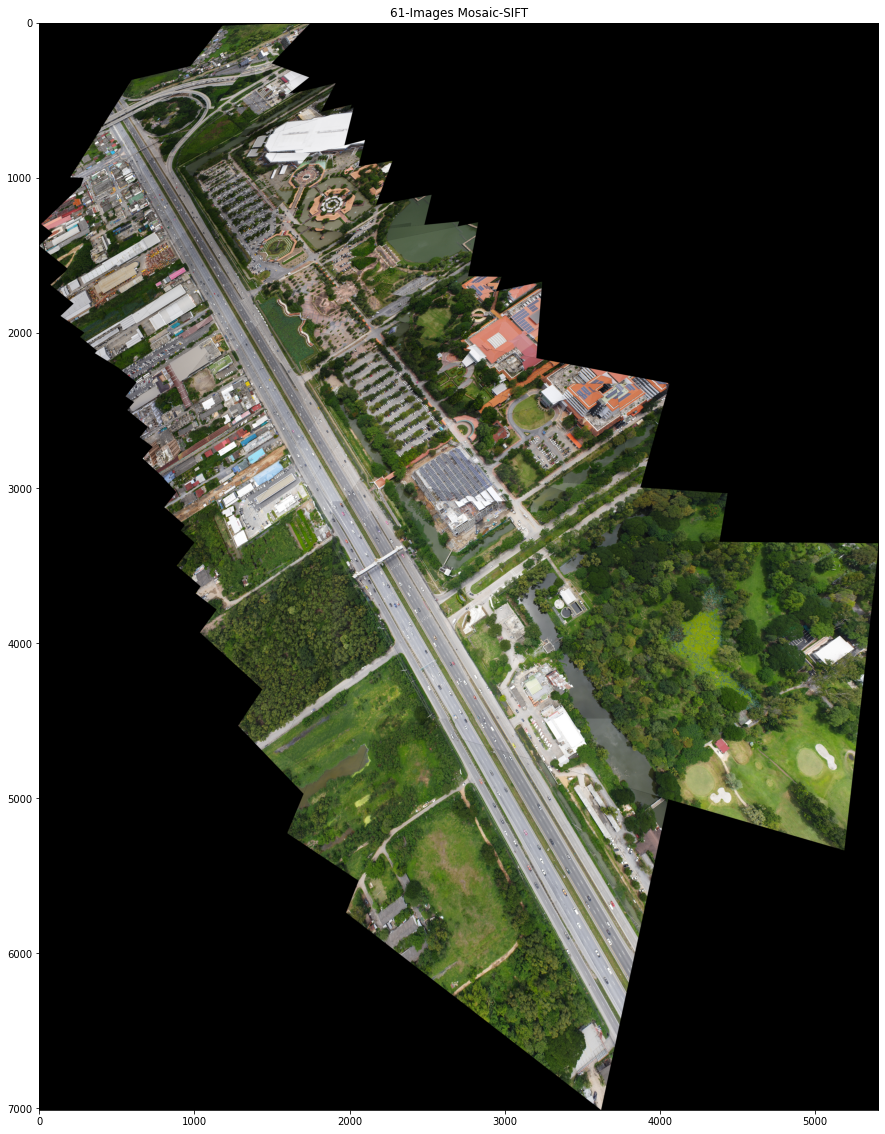

In [44]:
fig,ax =plt.subplots()
fig.set_size_inches(20,20)
ax.imshow(cv2.cvtColor(warp_imgs_all_sift , cv2.COLOR_BGR2RGB))
ax.set_title('61-Images Mosaic-SIFT')

In [45]:
fig.savefig('drive/MyDrive/61.png',dpi=300)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_rootsift,H_right_rootsift)

Step1:Done
Step2:Done
time: 2.82 ms (started: 2021-06-15 15:10:58 +00:00)


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step31:Done
time: 41.1 s (started: 2021-06-15 15:10:58 +00:00)


In [ ]:
warp_imgs_all_rootsift = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_rootsift,xmax,xmin,ymax,ymin,t,h,w,Ht)

Step32:Done
time: 36.7 s (started: 2021-06-15 15:11:39 +00:00)


In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_orb,H_right_orb)

Step1:Done
Step2:Done
time: 3.51 ms (started: 2021-06-15 15:12:16 +00:00)


In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_orb = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_orb,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_kaze,H_right_kaze)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_kaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_kaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_kaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_akaze,H_right_akaze)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_akaze = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_akaze,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_surf,H_right_surf)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_surf = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_surf,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_brief,H_right_brief)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_brief,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_brief = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_brief,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
xmax,xmin,ymax,ymin,t,h,w,Ht = warpnImages(images_left_bgr_no_enhance, images_right_bgr_no_enhance,H_left_superpoint,H_right_superpoint)

In [ ]:
warp_imgs_left = final_steps_left_union(images_left_bgr_no_enhance,H_left_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
warp_imgs_all_superpoint = final_steps_right_union(warp_imgs_left,images_right_bgr_no_enhance,H_right_superpoint,xmax,xmin,ymax,ymin,t,h,w,Ht)

In [ ]:
plt.figure(figsize = (25,25))

plt.imshow(cv2.cvtColor(warp_imgs_all , cv2.COLOR_BGR2RGB))
plt.title('61-Images Mosaic-SIFT')

In [ ]:
plt.savefig('drive/MyDrive/61Images_Mosaic_sift.png',dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

time: 254 ms (started: 2021-06-15 13:02:01 +00:00)


In [ ]:
plt.show()

time: 745 µs (started: 2021-06-15 13:02:33 +00:00)
